In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

In [2]:
import os
os.environ['OMP_NUM_THREADS'] = '30'

In [178]:
import numpy as np
import pandas as pd

from sklearn.ensemble import IsolationForest as SkForest
from coniferest.isoforest import IsolationForest, IsolationForestAnomalyDetector
from coniferest.aadforest import AADForest, AADForestAnomalyDetector
from coniferest.pineforest import PineForest, PineForestAnomalyDetector, ConiferestEvaluator
from coniferest.datasets import MalanchevDataset, Dataset
from coniferest.datasets import Label
from coniferest.experiment import AnomalyDetectionExperiment
import matplotlib.pyplot as plt


import sklearn.decomposition

import gzip

In [4]:
class WeatherData(Dataset):
    "Weather dataset"
    def __init__(self):
        with gzip.open('../datasets/weather/NEweather_data.csv.gz', 'rt') as file:
            self.data = np.genfromtxt(file, delimiter=',')

        with gzip.open('../datasets/weather/NEweather_class.csv.gz', 'rt') as file:
            labels = np.genfromtxt(file, delimiter=',')
            labels[labels == 2] = -1
            self.labels = labels

In [89]:
class ELAsTiCC(Dataset):
    "ELAsTiCC dataset"
    def __init__(self, anomaly_classes=None, regular_classes=None, transformed=True, downsample_ratio=1.0):
        dir = '../datasets/ELAsTiCC/'
        filename = 'features_transf.npy' if transformed else 'features.npy'
        self.data = np.load(dir + filename)
        self.ids = np.load(dir + 'ids.npy')
        self.types = np.load(dir + 'types.npy')

        labels = np.full_like(self.types, Label.R, dtype=Label)
        for klass in anomaly_classes:
            labels[self.types == klass] = Label.A

        self.labels = labels

        if regular_classes is not None:
            index = np.full(labels.shape, False)
            for klass in regular_classes:
                index |= (self.types == klass)
        else:
            index = np.full(labels.shape, True)

        # In case we'd like to downsample
        if downsample_ratio != 1.0:
            anomalies, = np.where(labels == Label.A)
            pivot = np.int(downsample_ratio * len(anomalies))
            index[anomalies[pivot:]] = False
            index[anomalies[:pivot]] = True


        self.labels = self.labels[index]
        self.ids = self.ids[index]
        self.types = self.types[index]
        self.data = self.data[index, :]

In [209]:
class PLAsTiCC(Dataset):
    "PLAsTiCC dataset"
    def __init__(self, anomaly_class='sne'):
        "Anomaly_class may be sne, 91bg, microlens, pisn"
        dir = '../datasets/PLAsTiCC/'
        data_df = pd.read_csv(dir + 'cut_extrapol_-20.0_100.0_g,r,i.csv')
        labels_df = pd.read_csv(dir + f'answers_{anomaly_class}.csv')

        lc_data = data_df.loc[:, 'g-20':'i+100'].to_numpy()
        lc_data_norm = np.amax(lc_data, axis=1).reshape(-1, 1)
        theta_data = data_df.loc[:, 'log_likehood':'theta_8'].to_numpy()
        theta_data_norm = np.amax(theta_data, axis=0) - np.amin(theta_data, axis=0)
        theta_data = theta_data / theta_data_norm
        data = np.hstack([lc_data / lc_data_norm, -2.5 * np.log10(lc_data_norm), theta_data])

        labels = labels_df['is_anomaly'].to_numpy()
        labels[labels == 1] = Label.A
        labels[labels == 0] = Label.R

        super(PLAsTiCC, self).__init__(data.copy(order='C'), labels)
        self.ids = data_df['object_id'].to_numpy()

In [191]:
class GalaxyZoo2(Dataset):
    "Galaxy Zoo 2 dataset"
    def __init__(self):
        path = '../datasets/gz2/astronomaly.parquet'
        tbl = pd.read_parquet(path)
        print(tbl.columns)
        self.data = tbl.drop(columns=['GalaxyID', 'anomaly']).to_numpy().copy(order='C')
    
        anomaly = tbl['anomaly'].to_numpy()
        labels = np.full(anomaly.shape, Label.R)
        labels[anomaly] = Label.A
        self.labels = labels
        
        self.ids = tbl['GalaxyID'].to_numpy()

In [154]:
class CompareThem:
    def __init__(self, dataset, pca=None, capacity=300, options={}):
        self.dataset = dataset
        
        if pca is not None:
            pca_algo = sklearn.decomposition.PCA(n_components=pca)
            data = pca_algo.fit_transform(dataset.data)
        else:
            data = dataset.data
        
        isoforest = IsolationForest(**options.get('isoforest', {}))
        isoforest_det = IsolationForestAnomalyDetector(isoforest)
        self.isoforest_exp = AnomalyDetectionExperiment(isoforest_det, data, dataset.labels, capacity=capacity)
        
        aadforest = AADForest(**options.get('aadforest', {}))
        aadforest_det = AADForestAnomalyDetector(aadforest)
        self.aadforest_exp = AnomalyDetectionExperiment(aadforest_det, data, dataset.labels, capacity=capacity)
    
        pineforest = PineForest(**options.get('pineforest', {}))
        pineforest_det = PineForestAnomalyDetector(pineforest)
        self.pineforest_exp = AnomalyDetectionExperiment(pineforest_det, data, dataset.labels, capacity=capacity)
        
    def run(self, tqdm=False):
        self.isoforest_exp.run(tqdm=tqdm)
        self.aadforest_exp.run(tqdm=tqdm)
        self.pineforest_exp.run(tqdm=tqdm)
    
    def plot(self):
        plt.figure(figsize=(8, 6))
        plt.title('AD performance curves')
        
        def performance(exp):
            return np.cumsum(exp.data_labels[exp.trajectory] == Label.A)

        if self.isoforest_exp.trace is not None:
            plt.plot(performance(self.isoforest_exp), label='Isolation Forest')
        
        if self.pineforest_exp.trace is not None:
            plt.plot(performance(self.pineforest_exp), label='Pine Forest')
        
        if self.aadforest_exp.trace is not None:
            plt.plot(performance(self.aadforest_exp), label='AAD Isolation Forest')

        plt.xlabel('number of iteration')
        plt.ylabel('true anomalies detected')
        plt.grid()
        plt.legend()
        pass

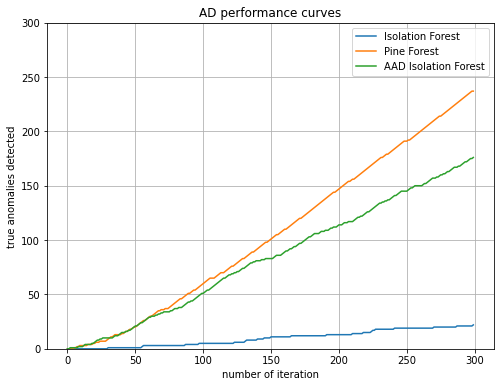

In [21]:
weather_cmp = CompareThem(WeatherData())
weather_cmp.run()
weather_cmp.plot()

CPU times: user 2h 31min 43s, sys: 6min 5s, total: 2h 37min 48s
Wall time: 8min 45s


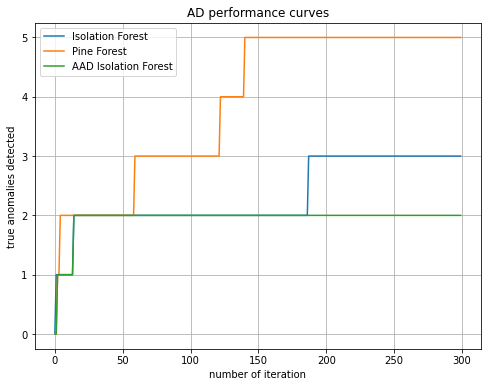

In [10]:
%%time

elasticc_cmp_1 = CompareThem(ELAsTiCC(anomaly_classes=['dwarf-nova']))
elasticc_cmp_1.run()
elasticc_cmp_1.plot()

CPU times: user 2h 17min 51s, sys: 5min 6s, total: 2h 22min 57s
Wall time: 8min 15s


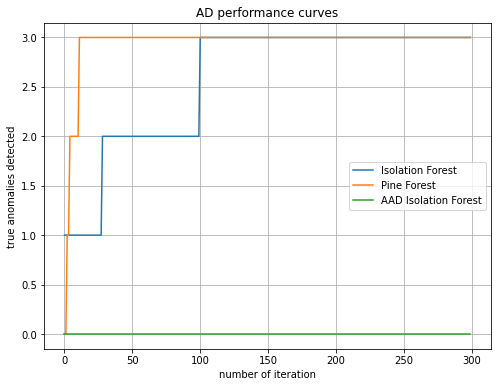

In [11]:
%%time

allopts = { }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_2 = CompareThem(ELAsTiCC(anomaly_classes=['dwarf-nova']))
elasticc_cmp_2.run()
elasticc_cmp_2.plot()

CPU times: user 2h 30min 44s, sys: 5min 24s, total: 2h 36min 9s
Wall time: 8min 33s


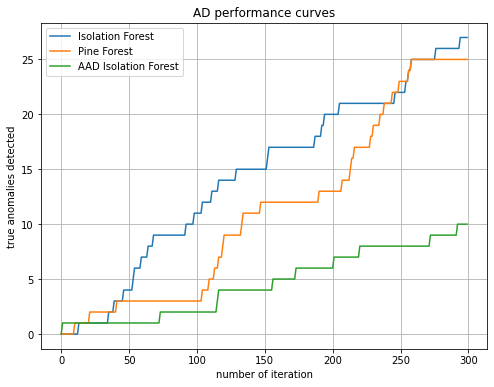

In [20]:
%%time

allopts = { }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_3 = CompareThem(ELAsTiCC(anomaly_classes=['uLens-Binary']))
elasticc_cmp_3.run()
elasticc_cmp_3.plot()

CPU times: user 2h 47min 21s, sys: 6min 23s, total: 2h 53min 44s
Wall time: 9min 13s


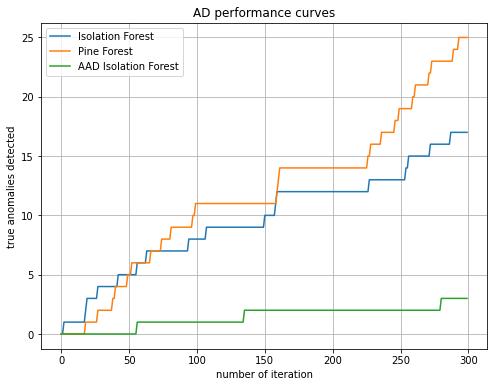

In [21]:
%%time

allopts = { 'n_subsamples': 1024 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_4 = CompareThem(ELAsTiCC(anomaly_classes=['uLens-Binary']))
elasticc_cmp_4.run()
elasticc_cmp_4.plot()

CPU times: user 1h 14min 3s, sys: 1min 55s, total: 1h 15min 59s
Wall time: 5min 32s


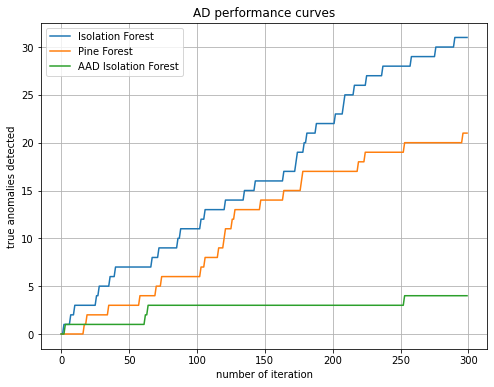

In [22]:
%%time

allopts = { 'n_subsamples': 1024, 'n_trees': 1000 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_5 = CompareThem(ELAsTiCC(anomaly_classes=['uLens-Binary']))
elasticc_cmp_5.run()
elasticc_cmp_5.plot()

CPU times: user 2h 28min 43s, sys: 5min 40s, total: 2h 34min 23s
Wall time: 8min 30s


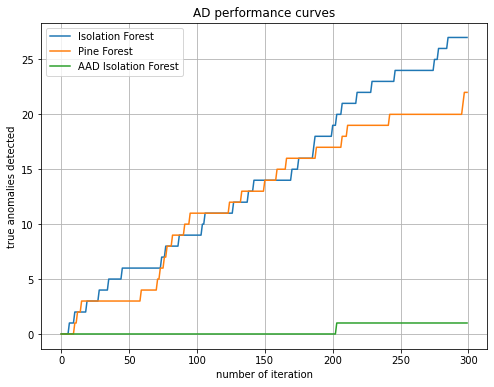

In [28]:
%%time

allopts = { 'n_subsamples': 1024, 'n_trees': 1000 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_6 = CompareThem(ELAsTiCC(anomaly_classes=['uLens-Binary']))
elasticc_cmp_6.run()
elasticc_cmp_6.plot()

CPU times: user 1h 53min 11s, sys: 4min 57s, total: 1h 58min 9s
Wall time: 7min 12s


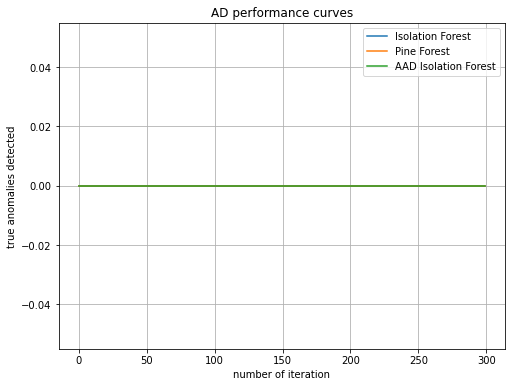

In [56]:
%%time

allopts = { 'n_subsamples': 1024, 'n_trees': 1000 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_6 = CompareThem(ELAsTiCC(anomaly_classes=['PISN'], downsample_ratio=0.02))
elasticc_cmp_6.run()
elasticc_cmp_6.plot()

In [67]:
e = ELAsTiCC(anomaly_class='dwarf-nova')
display(pd.DataFrame(np.unique(e.types, return_counts=True)).T)

,0,1
0,AGN,24992
1,CART,523
2,Cepheid,14169
3,EB,26961
4,ILOT,1848
5,PISN,24077
6,RRL,18576
7,SLSN-I+host,27557
8,SNII+HostXT_V19,3254
9,SNII-NMF,1804


CPU times: user 2h 2min 38s, sys: 5min 6s, total: 2h 7min 44s
Wall time: 7min 32s


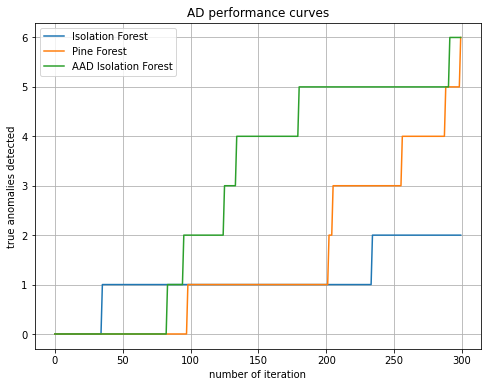

In [83]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

# 'Cepheid'
elasticc_cmp_7 = CompareThem(ELAsTiCC(regular_classes=['AGN', 'SLSN-I+host'], anomaly_class=['PISN'], downsample_ratio=0.02))
elasticc_cmp_7.run()
elasticc_cmp_7.plot()

CPU times: user 1h 35min 17s, sys: 4min 11s, total: 1h 39min 29s
Wall time: 6min 24s


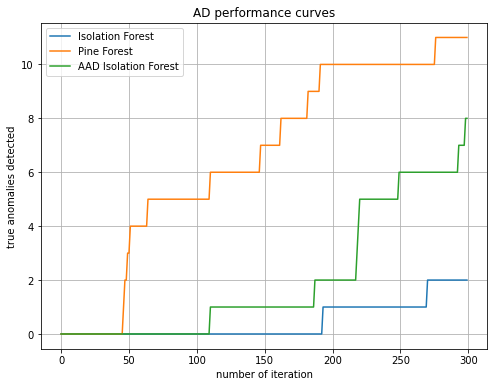

In [84]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_8 = CompareThem(ELAsTiCC(regular_classes=['SLSN-I+host'], anomaly_classes=['PISN'], downsample_ratio=0.02))
elasticc_cmp_8.run()
elasticc_cmp_8.plot()

CPU times: user 1h 18min 34s, sys: 3min 27s, total: 1h 22min 2s
Wall time: 3min 50s


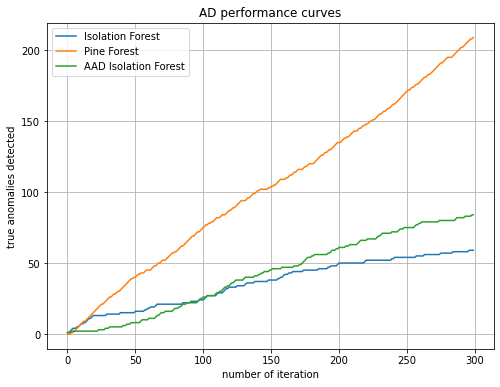

In [85]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }

elasticc_cmp_9 = CompareThem(ELAsTiCC(regular_classes=['AGN'], anomaly_classes=['PISN'], downsample_ratio=0.02))
elasticc_cmp_9.run()
elasticc_cmp_9.plot()

CPU times: user 1h 6min 20s, sys: 1min 43s, total: 1h 8min 4s
Wall time: 5min 22s


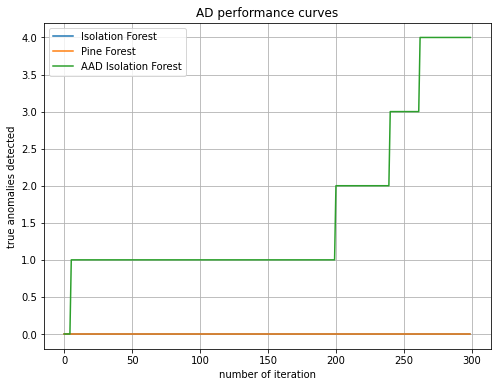

In [95]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }


elasticc_cmp_10 = CompareThem(ELAsTiCC(anomaly_classes=['TDE'], downsample_ratio=0.03))
elasticc_cmp_10.run()
elasticc_cmp_10.plot()

CPU times: user 2h 13min 9s, sys: 5min 17s, total: 2h 18min 27s
Wall time: 8min


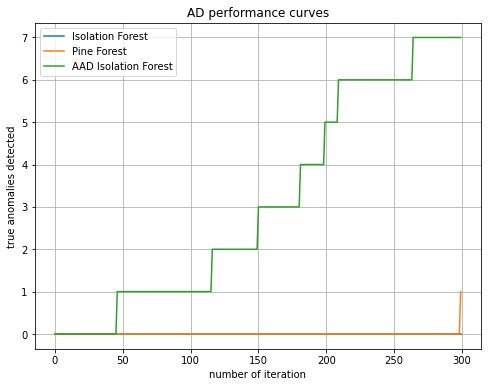

In [96]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }


elasticc_cmp_11 = CompareThem(ELAsTiCC(anomaly_classes=['SLSN-I+host', 'PISN'], downsample_ratio=0.03))
elasticc_cmp_11.run()
elasticc_cmp_11.plot()

100%|██████████| 300/300 [01:54<00:00,  2.63it/s]

CPU times: user 2h 2min 55s, sys: 7min 7s, total: 2h 10min 2s
Wall time: 6min 44s


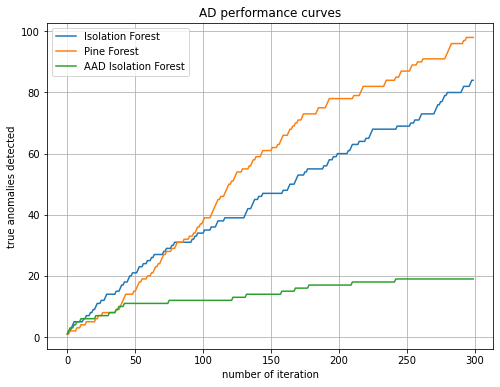

In [124]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }


gz_1 = CompareThem(GalaxyZoo2())
gz_1.run(tqdm=True)
gz_1.plot()

100%|██████████| 2000/2000 [17:51<00:00,  1.87it/s]

CPU times: user 48min 11s, sys: 8.35 s, total: 48min 19s
Wall time: 17min 51s


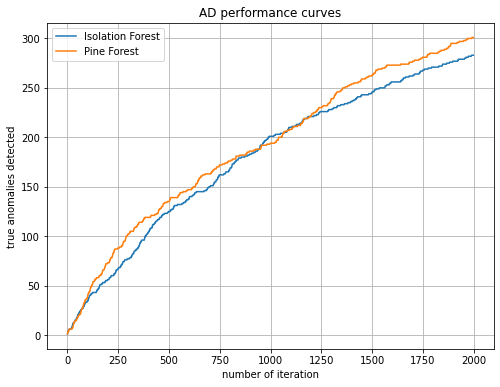

In [187]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 3000 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_20 = CompareThem(GalaxyZoo2(), capacity=2000)
gz_20.isoforest_exp.run(tqdm=True)
gz_20.pineforest_exp.run(tqdm=True)
gz_20.plot()

Index(['Residual_90', 'Residual_80', 'Residual_70', 'Residual_60',
       'Residual_50', 'Residual_0', 'Offset_90', 'Offset_80', 'Offset_70',
       'Offset_60', 'Offset_50', 'Offset_0', 'Aspect_90', 'Aspect_80',
       'Aspect_70', 'Aspect_60', 'Aspect_50', 'Aspect_0', 'Theta_90',
       'Theta_80', 'Theta_70', 'Theta_60', 'Theta_50', 'Theta_0', 'Maj_90',
       'Maj_80', 'Maj_70', 'Maj_60', 'Maj_50', 'Maj_0', 'GalaxyID', 'anomaly'],
      dtype='object')


100%|██████████| 2000/2000 [18:16<00:00,  1.82it/s]

CPU times: user 41min 14s, sys: 8.76 s, total: 41min 23s
Wall time: 18min 17s


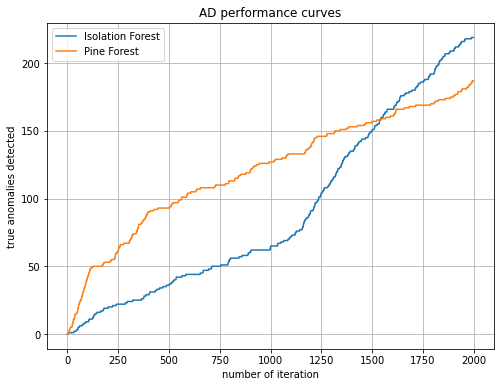

In [193]:
%%time

allopts = { 'n_subsamples': 256 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_21 = CompareThem(GalaxyZoo2(), capacity=2000)
gz_21.isoforest_exp.run(tqdm=True)
gz_21.pineforest_exp.run(tqdm=True)
gz_21.plot()

Index(['Residual_90', 'Residual_80', 'Residual_70', 'Residual_60',
       'Residual_50', 'Residual_0', 'Offset_90', 'Offset_80', 'Offset_70',
       'Offset_60', 'Offset_50', 'Offset_0', 'Aspect_90', 'Aspect_80',
       'Aspect_70', 'Aspect_60', 'Aspect_50', 'Aspect_0', 'Theta_90',
       'Theta_80', 'Theta_70', 'Theta_60', 'Theta_50', 'Theta_0', 'Maj_90',
       'Maj_80', 'Maj_70', 'Maj_60', 'Maj_50', 'Maj_0', 'GalaxyID', 'anomaly'],
      dtype='object')


100%|██████████| 2000/2000 [18:19<00:00,  1.82it/s]

CPU times: user 41min 44s, sys: 10.6 s, total: 41min 55s
Wall time: 18min 20s


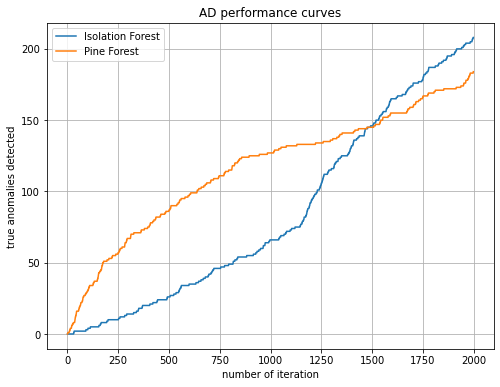

In [194]:
%%time

allopts = { 'n_subsamples': 1024, 'n_trees': 3000 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_20 = CompareThem(GalaxyZoo2(), capacity=2000)
gz_20.isoforest_exp.run(tqdm=True)
gz_20.pineforest_exp.run(tqdm=True)
gz_20.plot()

100%|██████████| 300/300 [01:54<00:00,  2.61it/s]

CPU times: user 5min 38s, sys: 1.08 s, total: 5min 39s
Wall time: 1min 55s


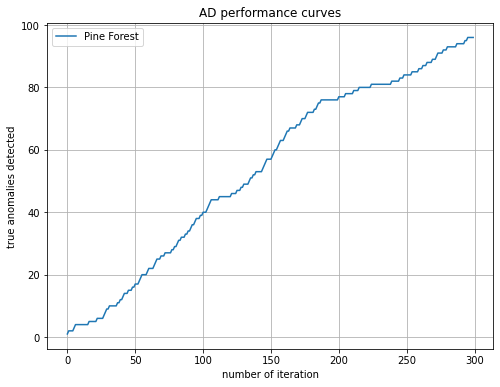

In [149]:
%%time

allopts = { 'n_subsamples': 1024 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 400
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


gz_22 = CompareThem(GalaxyZoo2())
gz_22.pineforest_exp.run(tqdm=True)
gz_22.plot()

100%|██████████| 300/300 [01:52<00:00,  2.67it/s]

CPU times: user 3h 5min 58s, sys: 11min 22s, total: 3h 17min 21s
Wall time: 9min 20s


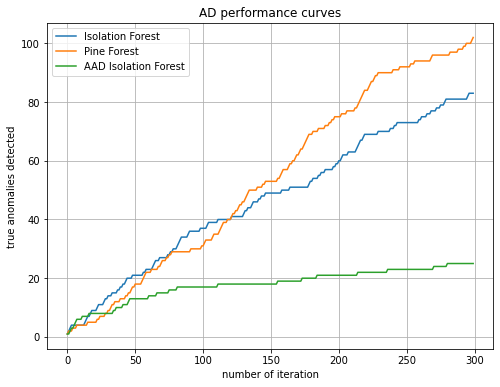

In [125]:
%%time

allopts = { 'n_subsamples': 1024, 'n_trees': 300 }
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': allopts }


gz_3 = CompareThem(GalaxyZoo2())
gz_3.run(tqdm=True)
gz_3.plot()

In [185]:
%%time

dataset = GalaxyZoo2()
pineforest = PineForest()
trees = pineforest.trees

for n in [48, 100, 220, 480, 1000, 2200, 10000, 22000]:
    trees.extend(pineforest.build_trees(dataset.data, n - len(trees)))
    pineforest.evaluator = ConiferestEvaluator(pineforest)
    scores = pineforest.evaluator.score_samples(dataset.data)
    print(f'{n:4d}', np.argsort(scores)[:10])

  48 [ 4182 62240  1904 23371 61729 62043 50082 12451 26864 62335]
 100 [ 1904 62240  4182 23371 61729 62335 62043 12451 61643 21109]
 220 [62240 62335 61729  4182 23371  1904 61643 12451 17112 62156]
 480 [62240 62335 61729  4182 12451  1904 17112 61643 23371 62156]
1000 [62240 62335 61729  4182 12451 23371 62156 61643  1904 31897]
2200 [62335 61729 62240  4182 12451 61643 23371 62156  1904 19108]
10000 [61729 62335 62240  4182 12451 23371 61643 62156 31897 19108]
22000 [61729 62335 62240  4182 12451 23371 61643 62156 31897 19108]
CPU times: user 5min 11s, sys: 1.61 s, total: 5min 13s
Wall time: 46 s


100%|██████████| 300/300 [01:13<00:00,  4.10it/s]

CPU times: user 2h 1min 34s, sys: 6min 2s, total: 2h 7min 37s
Wall time: 10min 56s


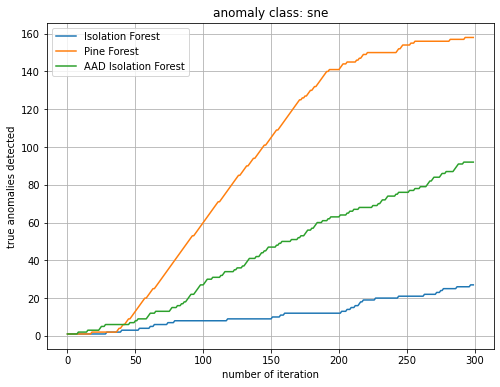

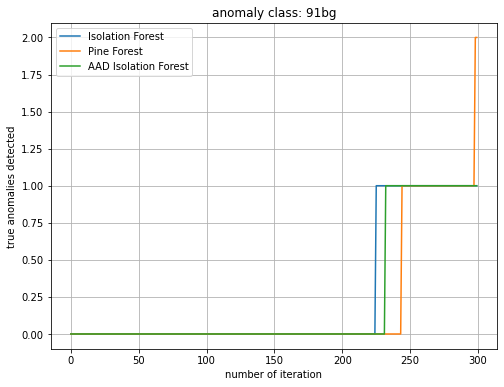

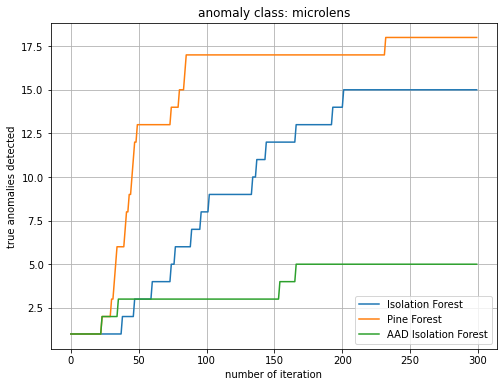

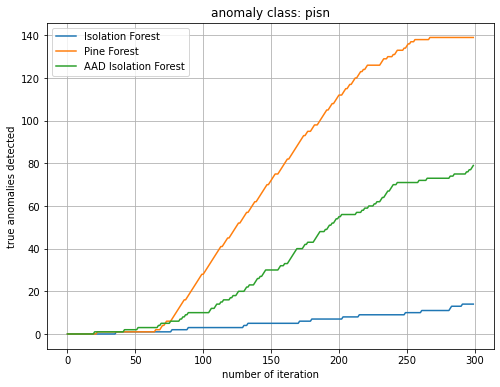

In [210]:
%%time

allopts = { 'n_subsamples': 256, 'n_trees': 100 }
pineopts = allopts.copy()
pineopts['n_spare_trees'] = 900
options = { 'isoforest': allopts, 'aadforest': allopts, 'pineforest': pineopts }


for aclass in ['sne', '91bg', 'microlens', 'pisn']:
    pc = CompareThem(PLAsTiCC(anomaly_class=aclass))
    pc.run(tqdm=True)››
    pc.plot()
    plt.title(f'anomaly class: {aclass}')

In [211]:
t = pc.isoforest_exp.regressor.isoforest.trees[0]